<>:41: SyntaxWarning: invalid escape sequence '\l'
<>:43: SyntaxWarning: invalid escape sequence '\l'
<>:41: SyntaxWarning: invalid escape sequence '\l'
<>:43: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_331225/3440290832.py:41: SyntaxWarning: invalid escape sequence '\l'
  plt.title('Scaling of Cubic Eigenvalue $\lambda_3$ with Dimension $d$')
/tmp/ipykernel_331225/3440290832.py:43: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('Variance $\lambda_3$')


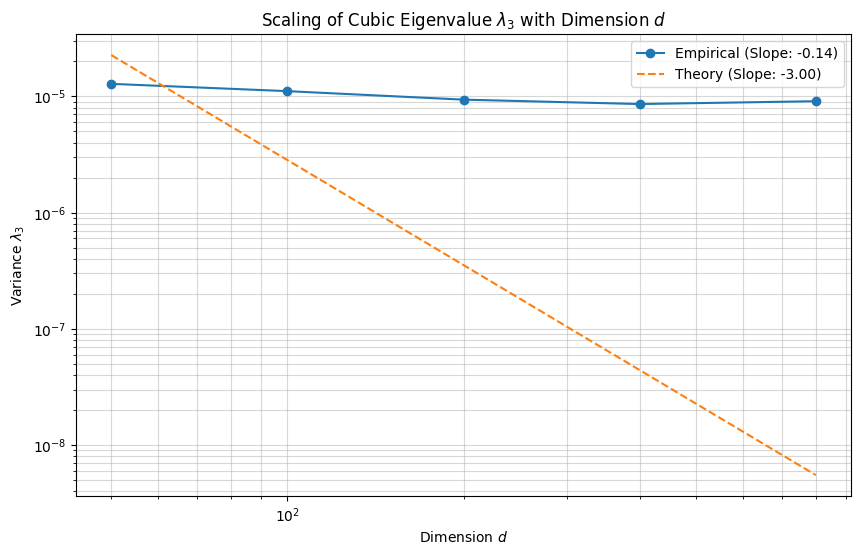

Empirical scaling: d^-0.14
Theoretical scaling: d^-3.00


In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

def get_emp_var(d, P=50000, n_ens=20000):
    sigma_w2 = 1.0 / d
    X = torch.randn(P, d)
    vx = X[:, 0]
    
    # Orthogonalized Cubic Feature
    phi_h1 = vx / (vx.norm() / np.sqrt(P))
    h3_raw = (vx**3 - 3*vx) / np.sqrt(6)
    h3_clean = h3_raw - (torch.dot(h3_raw, phi_h1)/P) * phi_h1
    phi_h3 = h3_clean / (h3_clean.norm() / np.sqrt(P))

    # Field realization
    W = torch.randn(n_ens, d) * np.sqrt(sigma_w2)
    # Projections: (n_ens, P) @ (P, 1) -> (n_ens, 1)
    projections = torch.matmul(torch.erf(torch.matmul(W, X.t())), phi_h3) / P
    
    return torch.var(projections).item()

# 1. Sweep across dimensions
d_values = np.array([50, 100, 200, 400, 800])
emp_vars = [get_emp_var(d) for d in d_values]

# 2. Compute Theory Values
# Theory: 16 * 15 * (1/d)^3 / (27 * pi)
theory_vars = (16 * 15 * (1.0/d_values)**3) / (np.pi * (1 + 2 * 1.0)**3)

# 3. Calculate Slopes (Linear regression in log-log space)
slope_emp, intercept_emp, _, _, _ = linregress(np.log(d_values), np.log(emp_vars))
slope_theo, intercept_theo, _, _, _ = linregress(np.log(d_values), np.log(theory_vars))

# 4. Plotting
plt.figure(figsize=(10, 6))
plt.loglog(d_values, emp_vars, 'o-', label=f'Empirical (Slope: {slope_emp:.2f})')
plt.loglog(d_values, theory_vars, '--', label=f'Theory (Slope: {slope_theo:.2f})')

plt.title('Scaling of Cubic Eigenvalue $\lambda_3$ with Dimension $d$')
plt.xlabel('Dimension $d$')
plt.ylabel('Variance $\lambda_3$')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()
plt.show()

print(f"Empirical scaling: d^{slope_emp:.2f}")
print(f"Theoretical scaling: d^{slope_theo:.2f}")

In [1]:
import sys
sys.path.append("../julia_lib")
sys.path.append("../lib")

from FCN2Network import *

Jensen Inequality Correction



In [3]:
import torch
import numpy as np
from tqdm import tqdm

def compute_lambda3_streaming(W0, P_total, batch_size=20000, ens=1, device="cuda:0"):
    dtype = torch.float64
    ens, n1, d = W0.shape
    sigma_w2 = 1.0 / d
    
    # --- NEW: Compute Weight Statistics ---
    # Squared norms of each neuron's weight vector: shape (ens, n1)
    w_norms_sq = torch.sum(W0**2, dim=2)
    avg_norm_sq = torch.mean(w_norms_sq).item()
    std_norm_sq = torch.std(w_norms_sq).item()
    
    # Jensen's Inequality check: Compare 1/(1+2*avg)^3 vs mean(1/(1+2*norm)^3)
    # This is exactly the "Denominator Bias" we suspected.
    theoretical_damping_factor = torch.mean(1.0 / (1 + 2 * w_norms_sq)**3).item()
    naive_damping_factor = 1.0 / (1 + 2 * 1.0)**3
    bias_correction = theoretical_damping_factor / naive_damping_factor
    # --------------------------------------

    torch.manual_seed(613)
    projections = torch.zeros(ens, n1, dtype=dtype, device=device)
    num_batches = P_total // batch_size
    remainder = P_total % batch_size
    
    print(f"Streaming P={P_total} | d={d} | n1={n1}")
    print(f"Weight Stats: Mean ||w||^2 = {avg_norm_sq:.4f}, Std = {std_norm_sq:.4f}")
    print(f"Bias Correction from Jensen's Inequality: {bias_correction:.6f}")

    with torch.no_grad():
        for i in tqdm(range(num_batches), desc="Processing Batches"):
            X_batch = torch.randn(batch_size, d, dtype=dtype, device=device)
            phi_3_batch = (X_batch[:, 0]**3 - 3*X_batch[:, 0]) / np.sqrt(6)
            h0 = torch.einsum('qkl,ul->qku', W0, X_batch)
            projections += torch.einsum('qku,u->qk', torch.erf(h0), phi_3_batch)

        if remainder > 0:
            X_rem = torch.randn(remainder, d, dtype=dtype, device=device)
            phi_3_rem = (X_rem[:, 0]**3 - 3*X_rem[:, 0]) / np.sqrt(6)
            projections += torch.einsum('qku,u->qk', torch.erf(torch.einsum('qkl,ul->qku', W0, X_rem)), phi_3_rem)

    projections /= P_total
    lambda_3_final = torch.var(projections).item()

    return lambda_3_final, theoretical_damping_factor

# --- Execution ---
dtype = torch.float64
device = "cuda:0"
ens = 1
d = 100
n1 = 10000
sigma_w2 = 1.0 / d
n1_val = 10000
P_val = 50_000_000
torch.manual_seed(42)
W0 = torch.empty(ens, n1, d, device=device).normal_(0.0, sigma_w2**0.5).to(dtype=dtype)



In [4]:
l3_emp, theoretical_damping = compute_lambda3_streaming(W0, P_val, batch_size=20000, ens=ens, device=device)


Streaming P=50000000 | d=100 | n1=10000
Weight Stats: Mean ||w||^2 = 0.9994, Std = 0.1404
Bias Correction from Jensen's Inequality: 1.054813


Processing Batches: 100%|██████████| 2500/2500 [02:15<00:00, 18.48it/s]


In [68]:
d = 100
# Theoretical Variance with original constant
sigma_w2 = 1.0 / d
constant_part = (16 * 15 * (sigma_w2**3)) / (np.pi * 6.0)
# 1. Naive theory (uses expectation of norm = 1.0)
theory_naive = constant_part / (1 + 2 * 1.0)**3
print("Theory naive (no bias correction):", theory_naive)

Theory naive (no bias correction): 4.71570201753764e-07


In [63]:

# Theoretical Variance with original constant
sigma_w2 = 1.0 / d
constant_part = (16 * 15 * (sigma_w2**3)) / (np.pi * 6.0)

# 1. Naive theory (uses expectation of norm = 1.0)
theory_naive = constant_part / (1 + 2 * 1.0)**3

# 2. Corrected theory (uses mean of the denominator across w)
theory_corrected = constant_part * theoretical_damping

print(f"\n--- Final Comparison ---")
print(f"Empirical λ3:   {l3_emp:.8e}")
print(f"Naive Theory:   {theory_naive:.8e} (Ratio: {l3_emp/theory_naive:.4f})")
print(f"Corrected Theory: {theory_corrected:.8e} (Ratio: {l3_emp/theory_corrected:.4f})")


--- Final Comparison ---
Empirical λ3:   1.35762377e-04
Naive Theory:   4.71570202e-07 (Ratio: 287.8943)
Corrected Theory: 4.97418595e-07 (Ratio: 272.9339)


In [46]:
import sys
sys.path.append("/home/akiva/FCNX-Ensembling/lib")

import torch
import numpy as np
from tqdm import tqdm
from FCN2Network import FCN2NetworkActivationGeneric



sigma_W0_sq = 1.0 / d
sigma_A_sq = 1.0 / (n1)

torch.manual_seed(42)
print("Initializing FCN2 model...")
model = FCN2NetworkActivationGeneric(
    d=d,
    n1=n1,
    P=None,  # not needed for this analysis
    ens=ens,
    activation="erf",
    weight_initialization_variance=(sigma_W0_sq, sigma_A_sq),
    device="cuda:0" if torch.cuda.is_available() else "cpu"
).to(dtype=torch.float64)

Initializing FCN2 model...


In [41]:
l3_emp, theoretical_damping = compute_lambda3_streaming(model.W0.detach().to(dtype), P_val, batch_size=20_000, device=device)
# Theoretical Variance with original constant
sigma_w2 = 1.0 / d_val
constant_part = (16 * 15 * (sigma_w2**3)) / (np.pi * 6.0)

# 1. Naive theory (uses expectation of norm = 1.0)
theory_naive = constant_part / (1 + 2 * 1.0)**3

# 2. Corrected theory (uses mean of the denominator across w)
theory_corrected = constant_part * theoretical_damping

print(f"\n--- Final Comparison ---")
print(f"Empirical λ3:   {l3_emp:.8e}")
print(f"Naive Theory:   {theory_naive:.8e} (Ratio: {l3_emp/theory_naive:.4f})")
print(f"Corrected Theory: {theory_corrected:.8e} (Ratio: {l3_emp/theory_corrected:.4f})")

Streaming P=50000000 | d=150 | n1=10000
Weight Stats: Mean ||w||^2 = 0.9985, Std = 0.1136
Bias Correction from Jensen's Inequality: 1.037962


Processing Batches: 100%|██████████| 2500/2500 [01:53<00:00, 22.07it/s]



--- Final Comparison ---
Empirical λ3:   1.52363952e-07
Naive Theory:   1.39724504e-07 (Ratio: 1.0905)
Corrected Theory: 1.45028739e-07 (Ratio: 1.0506)


In [54]:
device = "cuda:0"
torch.manual_seed(42)
std0 = np.sqrt(sigma_W0_sq)
W0 =  torch.empty(ens, n1, d, device=device).normal_(0.0, std0)

In [56]:
model.W0

Parameter containing:
tensor([[[ 0.0158,  0.1765, -0.0140,  ...,  0.0193, -0.0596, -0.1376],
         [ 0.0744,  0.0644, -0.0513,  ..., -0.0433, -0.1463, -0.0234],
         [ 0.0066, -0.1062,  0.1094,  ..., -0.0115,  0.1134,  0.0252],
         ...,
         [-0.0018, -0.0102,  0.0158,  ...,  0.0970, -0.0285,  0.1386],
         [ 0.0930,  0.0207, -0.1353,  ..., -0.1291,  0.1477, -0.0283],
         [-0.0320,  0.0981,  0.0762,  ...,  0.1083,  0.0538, -0.1553]]],
       device='cuda:0', dtype=torch.float64, requires_grad=True)

In [52]:
P_val

50000000

Streaming P=50000000 | d=100 | n1=800
Weight Stats: Mean ||w||^2 = 1.1367, Std = 0.1620
Bias Correction from Jensen's Inequality: 0.816087


Processing Batches: 100%|██████████| 2500/2500 [02:51<00:00, 14.62it/s]


Empirical λ3 (loaded model): 1.92398111e-05
Theoretical damping (loaded model): 3.02254272e-02


Found 4 models.

Model: model.pt
Avg ||w||^2: 1.142824, Std: 0.164103
lJ3_W0: 2.97860562e-04
lJ3_W0_naive: 2.80686788e-04

Model: model.pt
Avg ||w||^2: 1.143147, Std: 0.163918
lJ3_W0: 2.97697091e-04
lJ3_W0_naive: 2.80521521e-04

Model: model.pt
Avg ||w||^2: 1.142924, Std: 0.163413
lJ3_W0: 2.97715232e-04
lJ3_W0_naive: 2.80635727e-04

Model: model.pt
Avg ||w||^2: 1.143165, Std: 0.162911
lJ3_W0: 2.97469949e-04
lJ3_W0_naive: 2.80511986e-04


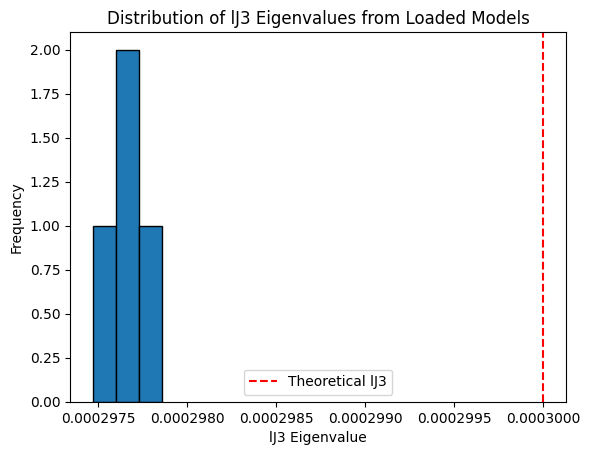

Average Percentage Error from Sigma-Corrected Theoretical Value: 0.77%
Average Percentage Error from Uncorrected Theoretical Value: 11.67%


In [107]:
import glob
import os

model_dir = "/home/akiva/FCNX-Ensembling/milestones/fcn2_erf_hidden_kernel"
pattern = os.path.join(model_dir, "d100_P1200_N800_chi_80.0_lr_3e-05_T_4.0_seed_*_eps_*/model.pt")
model_paths = glob.glob(pattern)
print(f"Found {len(model_paths)} models.")
results = []

for model_path in model_paths:
    state = torch.load(model_path, map_location=device)
    W0_loaded = state["W0"].to(dtype).to(device)
    # l3_emp_loaded, theoretical_damping_loaded = compute_lambda3_streaming(
    #     W0_loaded, P_val, batch_size=20000, ens=ens, device=device
    # )

    w_norms_sq = torch.sum(W0_loaded**2, dim=2)
    avg_norm_sq = torch.mean(w_norms_sq).item()
    std_norm_sq = torch.std(w_norms_sq).item()
    theoretical_damping_factor = torch.mean(1.0 / (1 + 2 * w_norms_sq)**3).item()
    naive_damping_factor = 1.0 / (1 + 2 * avg_norm_sq)**3
    bias_correction = theoretical_damping_factor / naive_damping_factor
    lW = W0_loaded[:,:,0].var()
    lJ3_pre = 0.0507**3 * 15 * 16 / (np.pi)
    lJ3_W0 = theoretical_damping_factor * lJ3_pre
    lJ3_W0_naive = naive_damping_factor * lJ3_pre

    results.append({
        "model_path": model_path,
        # "l3_emp_loaded": l3_emp_loaded,
        # "theoretical_damping_loaded": theoretical_damping_loaded,
        "avg_norm_sq": avg_norm_sq,
        "std_norm_sq": std_norm_sq,
        "theoretical_damping_factor": theoretical_damping_factor,
        "naive_damping_factor": naive_damping_factor,
        "bias_correction": bias_correction,
        "lW": lW.item(),
        "lJ3_W0": lJ3_W0,
        "lJ3_W0_naive": lJ3_W0_naive,
    })

for res in results:
    print(f"\nModel: {os.path.basename(res['model_path'])}")
    print(f"Avg ||w||^2: {res['avg_norm_sq']:.6f}, Std: {res['std_norm_sq']:.6f}")
    # print(f"Empirical λ3: {res['l3_emp_loaded']:.8e}")
    # print(f"Theoretical damping: {res['theoretical_damping_loaded']:.8e}")
    print(f"lJ3_W0: {res['lJ3_W0']:.8e}")
    print(f"lJ3_W0_naive: {res['lJ3_W0_naive']:.8e}")
# Plot the distribution of the lJ3 eigenvalues from results
lJ3_values = [res['lJ3_W0'] for res in results]
plt.hist(lJ3_values, bins=3, edgecolor='black')
plt.title('Distribution of lJ3 Eigenvalues from Loaded Models')

# Plot vertical line at the theoretical value = 0.000340842
plt.axvline(x=0.00030, color='r', linestyle='--', label='Theoretical lJ3')
plt.legend()
plt.xlabel('lJ3 Eigenvalue')
plt.ylabel('Frequency')
plt.show()

# Print the average percentage error from theoretical value
theoretical_value_sigma_corrected = 0.00030
theoretical_value_uncorrected = 0.000337
percentage_errors_corrected = [abs((val - theoretical_value_sigma_corrected) / theoretical_value_sigma_corrected) * 100 for val in lJ3_values]
avg_percentage_error_corrected = np.mean(percentage_errors_corrected)
print(f"Average Percentage Error from Sigma-Corrected Theoretical Value: {avg_percentage_error_corrected:.2f}%")

percentage_errors_uncorrected = [abs((val - theoretical_value_uncorrected) / theoretical_value_uncorrected) * 100 for val in lJ3_values]
avg_percentage_error_uncorrected = np.mean(percentage_errors_uncorrected)
print(f"Average Percentage Error from Uncorrected Theoretical Value: {avg_percentage_error_uncorrected:.2f}%")

In [92]:
# Gaussianity test on W0[:,:,0] weights in all models
all_W0_first_neuron = torch.cat([torch.load(res['model_path'])["W0"][:,:,0].flatten() for res in results], dim=0)
mean_W0 = torch.mean(all_W0_first_neuron).item()
std_W0 = torch.std(all_W0_first_neuron).item()
print(f"Mean of W0 first neuron weights: {mean_W0:.4f}")
print(f"Std of W0 first neuron weights: {std_W0:.4f}")
# Perform shapiro-wilk test for normality
from scipy.stats import shapiro
stat, p_value = shapiro(all_W0_first_neuron.cpu().numpy())
alpha = 0.05
if p_value > alpha:
    print("Fail to reject the null hypothesis: Data is normally distributed.")
else:
    print("Reject the null hypothesis: Data is not normally distributed.")
    chunk_size = 2048  # Process in chunks to save memory

Mean of W0 first neuron weights: 0.0017
Std of W0 first neuron weights: 0.2223
Reject the null hypothesis: Data is not normally distributed.


/home/akiva/miniconda3/envs/ml_env/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 32000.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
W0 = W0_loaded
# --- NEW: Compute Weight Statistics ---
# Squared norms of each neuron's weight vector: shape (ens, n1)
w_norms_sq = torch.sum(W0**2, dim=2)
avg_norm_sq = torch.mean(w_norms_sq).item()
std_norm_sq = torch.std(w_norms_sq).item()

# Jensen's Inequality check: Compare 1/(1+2*avg)^3 vs mean(1/(1+2*norm)^3)
# This is exactly the "Denominator Bias" we suspected.
theoretical_damping_factor = torch.mean(1.0 / (1 + 2 * w_norms_sq)**3).item()
naive_damping_factor = 1.0 / (1 + 2 * avg_norm_sq)**3
bias_correction = theoretical_damping_factor / naive_damping_factor
lW = W0_loaded[:,:,0].var()
lJ3_pre = 0.0507**3 * 15 * 16 / (np.pi )
lJ3_W0 = theoretical_damping_factor * lJ3_pre
lJ3_W0_naive = naive_damping_factor * lJ3_pre
# Print lJ3_W0 up to 8 decimal places
print(f"lJ3_W0: {lJ3_W0:.8e}")
print(f"lJ3_W0_naive: {lJ3_W0_naive:.8e}")

tensor(0.0496, device='cuda:0', dtype=torch.float64)

lJ3_W0: 3.00924602e-04
lJ3_W0_naive: 2.83833549e-04


In [102]:
import json
import numpy as np
import subprocess

# Save eigenvalues and kappa_bare to JSON file
eigs_np = eigs.cpu().numpy() 
data = {
    "eigenvalues": eigs_np.tolist(),
    "kappa_bare": 2.0  # Set this to your desired value if needed
}
with open("eigs.json", "w") as f:
    json.dump(data, f)

# Call the Julia script as a subprocess
result = subprocess.run(
    ["julia", "../julia_lib/self_consistent_kappa_solver.jl", "eigs.json", str(1200)],
    capture_output=True, text=True
)

print("Self-consistent kappa:", result.stdout.strip())

Self-consistent kappa: kappa_eff = 2.1632265108


In [57]:
lW.shape

torch.Size([10])

In [15]:
d = state["W0"].shape[2]
n1 = state["W0"].shape[1]
ens = state["W0"].shape[0]
sigma_W0_sq = 1.0 / d
sigma_A_sq = 1.0 / (n1 * 80)
# Generate model out of state dict
model_loaded = FCN2NetworkActivationGeneric(
    d=d,
    n1=n1,
    P=None,  # not needed for this analysis
    ens=ens,
    activation="erf",
    weight_initialization_variance=(sigma_W0_sq, sigma_A_sq),
    device="cuda:0" if torch.cuda.is_available() else "cpu"
).to(dtype=torch.float64)

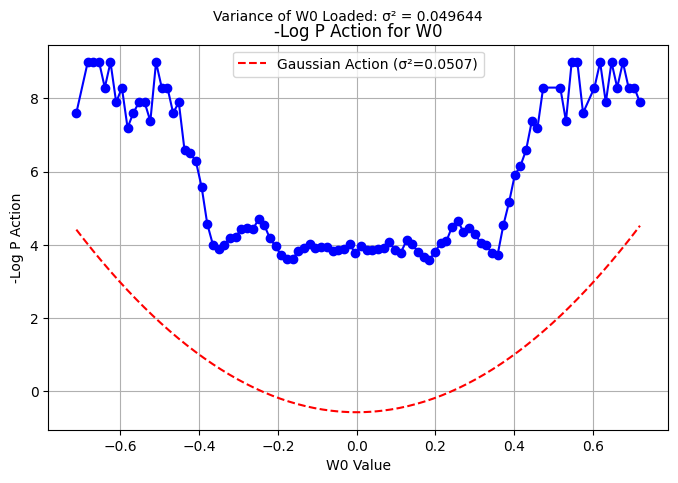

In [95]:
# Compute variance of W0_loaded nad plot -log P action 
import matplotlib.pyplot as plt
W0_variance = torch.var(W0_loaded[:,:,0]).item()

# Obtain density histogram data


# Create histogram
hist, bin_edges = np.histogram(W0_loaded[:,:,0].cpu().numpy().flatten(), density=True, bins=100)
bin_widths = np.diff(bin_edges)
probs = hist * bin_widths  # Convert density to probability
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Filter positive probabilities
mask = probs > 0
neg_log_probs = -np.log(probs[mask])



# Plot -Log P action
plt.figure(figsize=(8, 5))
plt.plot(bin_centers[mask], neg_log_probs, marker='o', linestyle='-', color='blue')
plt.title('-Log P Action for W0')
plt.xlabel('W0 Value')
plt.ylabel('-Log P Action')
plt.grid(True)

# Show the gaussian action for comparison with sigma^2 = 0.0.0507 including normalization
x_vals = np.linspace(bin_centers.min(), bin_centers.max(), 200)
gaussian_action = - np.log(1/np.sqrt(2 * np.pi * 0.0507)) + (x_vals**2) / (2 * 0.0507)
plt.plot(x_vals, gaussian_action, linestyle='--', color='red', label='Gaussian Action (σ²=0.0507)')
plt.legend()

# Show variance \sigma^2 in the title
plt.suptitle(f'Variance of W0 Loaded: σ² = {W0_variance:.6f}', y=0.95, fontsize=10)
plt.show()

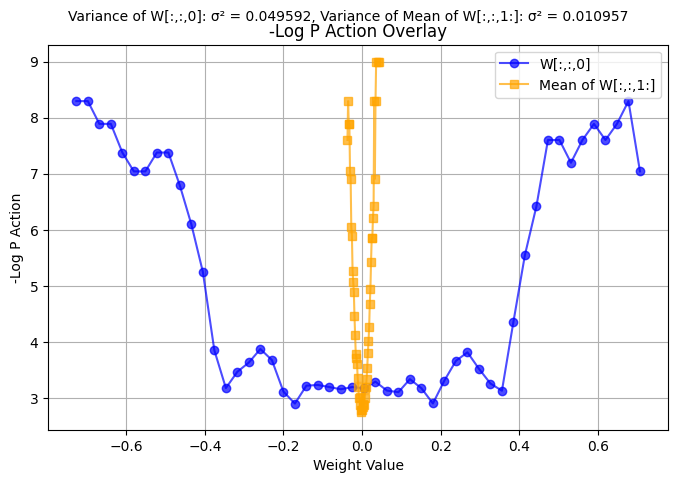

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 1. Prepare data for W[:,:,0]
w0_data = W0_loaded[:,:,0].cpu().numpy().flatten()
# 2. Prepare data for mean of W[:,:,1:]
w_mean_rest = W0_loaded[:,:,1:].mean(dim=-1).cpu().numpy().flatten()

def get_logp(data, bins=50):
    # Create histogram
    hist, bin_edges = np.histogram(data, density=True, bins=bins)
    bin_widths = np.diff(bin_edges)
    probs = hist * bin_widths  # Convert density to probability
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    neg_log_probs = -np.log(probs[probs > 0])
    return bin_centers[probs > 0], neg_log_probs

# Compute distributions
centers0, logP0 = get_logp(w0_data)
centers_mean, logP_mean = get_logp(w_mean_rest)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(centers0, logP0, marker='o', label='W[:,:,0]', color='blue', alpha=0.7)
plt.plot(centers_mean, logP_mean, marker='s', label='Mean of W[:,:,1:]', color='orange', alpha=0.7)

plt.title('-Log P Action Overlay')
plt.xlabel('Weight Value')
plt.ylabel('-Log P Action')
plt.legend()
plt.grid(True)

# Variance info
var0 = torch.var(W0_loaded[:,:,0]).item()
var_mean = torch.var(W0_loaded[:,:,1:], dim=-1).mean().item()
plt.suptitle(f'Variance of W[:,:,0]: σ² = {var0:.6f}, Variance of Mean of W[:,:,1:]: σ² = {var_mean:.6f}', y=0.95, fontsize=10)

plt.show()

In [38]:
Xinf = torch.randn(5000, d, dtype=dtype, device=device)
eigs = torch.linalg.eigvalsh(model_loaded.H_Kernel(Xinf)) / 5000

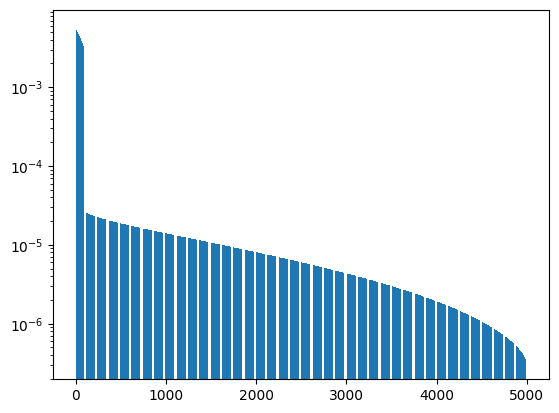

In [39]:
plt.bar(range(eigs.shape[0]), eigs.sort(descending=True)[0].cpu().numpy())
plt.yscale('log')

In [ ]:
mode